In [1]:
import config
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import cv2


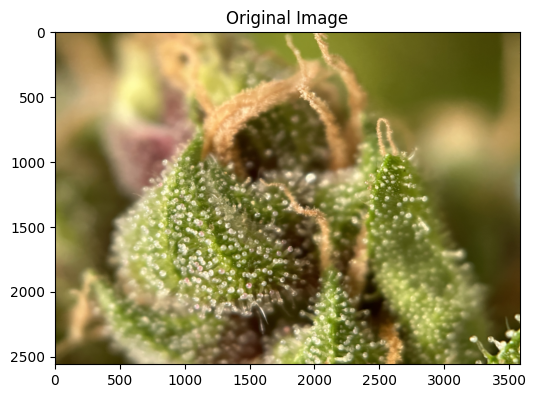

In [2]:
image_path = config.get_raw_image_path(week="week9", zoom_type="3xr") / "IMG_2305.JPG"
# Load and plot the original image
image = Image.open(image_path)  # Replace with your image path
image = np.array(image)

# Resize the image to fit 512 pixel size
def resize_to_fit(image, patch_size):
    new_height = (image.shape[0] // patch_size) * patch_size
    new_width = (image.shape[1] // patch_size) * patch_size
    return cv2.resize(image, (new_width, new_height))

resized_image = resize_to_fit(image, 512)

plt.figure(figsize=(6, 6))
plt.imshow(resized_image)
plt.title('Original Image')
plt.show()

In [3]:
resized_image.shape, image.shape

((2560, 3584, 3), (3024, 4032, 3))

In [9]:
3024 / 504, 4032 / 504

(6.0, 8.0)

In [4]:
import math
image_height = image.shape[0]
image_width = image.shape[1]
patch_size = 512

# Function to calculate the stride for a perfect fit
def calculate_stride_for_perfect_fit(image_dimension, patch_size):
    # Number of complete patches that can fit into the image dimension
    num_patches = math.ceil(image_dimension / patch_size)
    
    # If the image dimension is an exact multiple of the patch size
    if image_dimension % patch_size == 0:
        return patch_size
    else:
        # Calculating the stride for the perfect fit
        return (image_dimension - patch_size) // (num_patches - 1)

# Calculating the stride for both horizontal and vertical dimensions
stride_horizontal = calculate_stride_for_perfect_fit(image_width, patch_size)
stride_vertical = calculate_stride_for_perfect_fit(image_height, patch_size)

stride_horizontal, stride_vertical, stride_horizontal == stride_vertical

(502, 502, True)

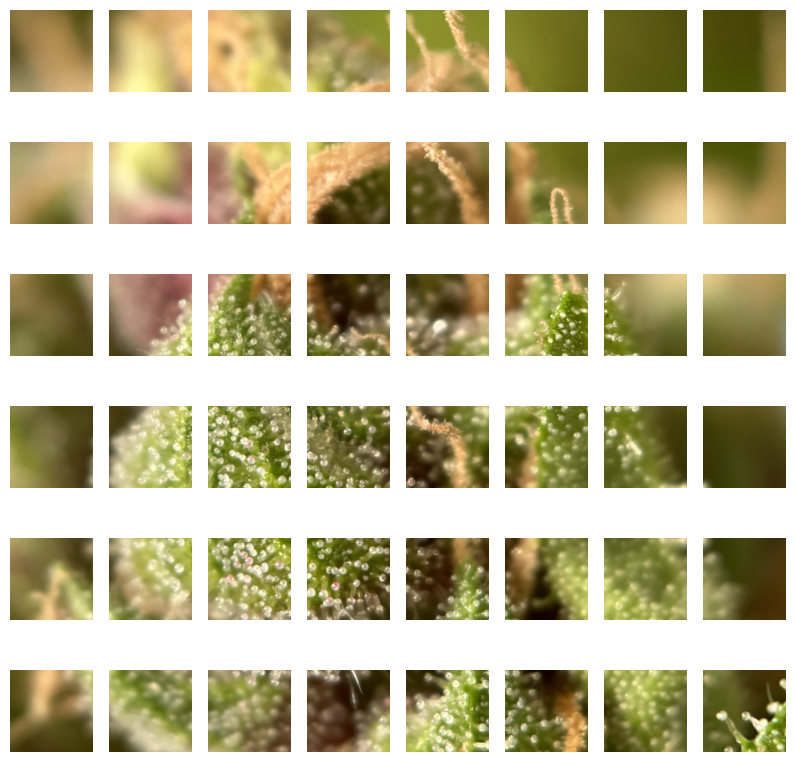

In [17]:
# Cut the image into 512x512 patches with windowing
# Patchify the image
patches = patchify(image, (512, 512, 3), step=502)

# Plot patches
fig, axs = plt.subplots(patches.shape[0], patches.shape[1], figsize=(10, 10))
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        axs[i, j].imshow(patches[i, j, 0, :, :, :])
        axs[i, j].axis('off')
plt.show()


In [14]:
# Unpatchify the image
reconstructed_image = unpatchify(patches, resized_image.shape)

# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.show()

NonUniformStepSizeError: Unpatchify only supports reconstructing image with a uniform step size for all patches. However, reconstructing 8 x 512px patches to an 3584 image requires 438.85714285714283 as step size, which is not an integer.

In [12]:
reconstructed_image.shape

(2560, 3584, 3)

Patchify wasnt a good method because it cant reconsruct the images with windowing

#### Cutting the Images with Reflect or Replicate

In [16]:
def pad_and_cut_images_reflect(image, patch_height=512, patch_width=512):
    # Calculate the required padding
    pad_height = (patch_height - image.shape[0] % patch_height) % patch_height
    pad_width = (patch_width - image.shape[1] % patch_width) % patch_width

    # Pad the image with reflect border
    padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_REFLECT)

    # Then cut the padded image into patches
    patches_with_coords = []
    for i in range(0, padded_image.shape[0], patch_height):
        for j in range(0, padded_image.shape[1], patch_width):
            patch = padded_image[i: i + patch_height, j: j + patch_width]
            patches_with_coords.append((patch, (i, j)))

    return patches_with_coords


def pad_and_cut_images_replicate(image, patch_height=512, patch_width=512):
    # Calculate the required padding
    pad_height = (patch_height - image.shape[0] % patch_height) % patch_height
    pad_width = (patch_width - image.shape[1] % patch_width) % patch_width

    # Pad the image with replicate border
    padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_REPLICATE)

    # Then cut the padded image into patches
    patches_with_coords = []
    for i in range(0, padded_image.shape[0], patch_height):
        for j in range(0, padded_image.shape[1], patch_width):
            patch = padded_image[i: i + patch_height, j: j + patch_width]
            patches_with_coords.append((patch, (i, j)))

    return patches_with_coords


# Function to plot patches in grid layout
def plot_patches_in_grid(patches, image_shape, patch_height=512, patch_width=512):
    rows = int(np.ceil(image_shape[0] / patch_height))
    cols = int(np.ceil(image_shape[1] / patch_width))
    fig, axs = plt.subplots(rows, cols, figsize=(8,8))
    for i, (patch, (x, y)) in enumerate(patches):
        axs[x // patch_height, y // patch_width].imshow(patch)
        axs[x // patch_height, y // patch_width].axis('off')
    plt.tight_layout()
    plt.show()

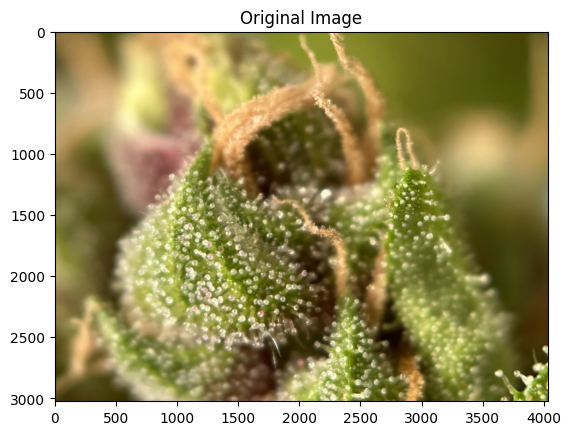

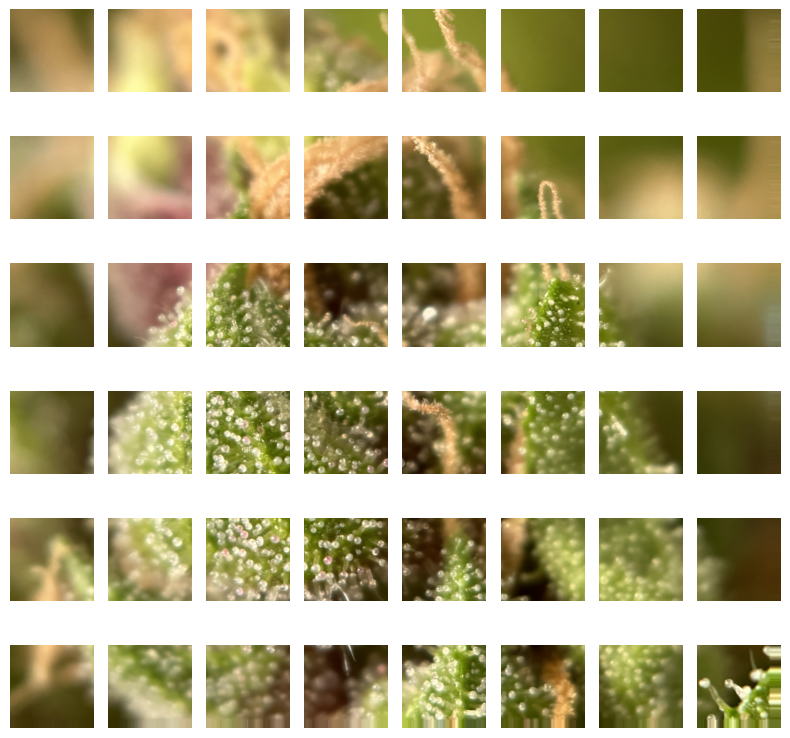

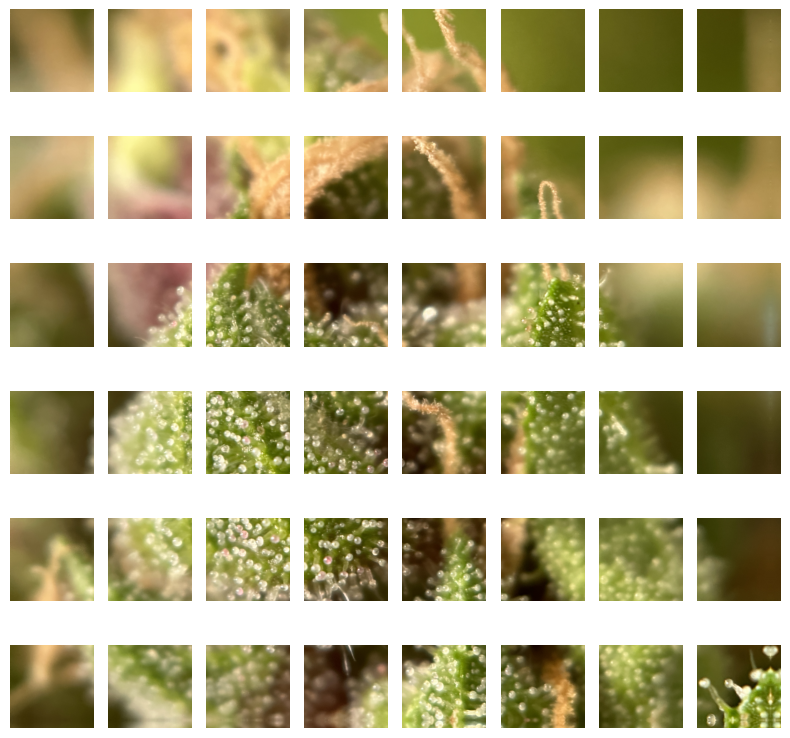

In [17]:
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Plot the original image
plt.imshow(image)
plt.title('Original Image')
plt.show()

# Apply the padding and cutting functions
replicate_patches = pad_and_cut_images_replicate(image)
reflect_patches = pad_and_cut_images_reflect(image)


# Plot the patches in grid layout
plot_patches_in_grid(replicate_patches, image.shape, 512, 512)
plot_patches_in_grid(reflect_patches, image.shape, 512, 512)

Seems like the replicate is a good method which i can use to extand the patches with more info